## Détection accoustique de nouveauté et d'anonmalie

Import du dataset ESC-50 disponible sur GitHub.

In [2]:
# 1. Installation des dépendances
!pip install librosa pandas matplotlib torch

# 2. Téléchargement du dataset ESC-50
import os
if not os.path.exists('ESC-50-master'):
    print("Téléchargement de ESC-50...")
    !wget https://github.com/karolpiczak/ESC-50/archive/master.zip
    !unzip -q master.zip
    !rm master.zip

print("Dataset prêt.")

Téléchargement de ESC-50...
--2026-02-01 14:00:51--  https://github.com/karolpiczak/ESC-50/archive/master.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master [following]
--2026-02-01 14:00:51--  https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.10
Connecting to codeload.github.com (codeload.github.com)|140.82.121.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 645695005 (616M) [application/zip]
Saving to: ‘master.zip’

master.zip          100%[===================>] 615.78M  41.4MB/s    in 15s     

2026-02-01 14:01:06 (40.6 MB/s) - ‘master.zip’ saved [645695005/645695005]

Dataset prêt.


In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import csv
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import Audio, display

In [36]:

# CONFIGURATION

# Paramètres audio
SR = 16000          # Fréquence d'échantillonnage (Hz)
MAX_LEN = 128       # Longueur maximale en frames temporelles

N_MELS = 54  # Comme dans l'article: 26 mel bands + 26 deltas + 2 energy = 54
HIDDEN_SIZE = 256  # Meilleure config selon article: 156-256-156
NUM_LAYERS = 2  # Pas 3 comme dans article pour simplifier
BIDIRECTIONAL = True  # BLSTM comme dans article
NOISE_STD = 0.25


# Paramètres d'entraînement
BATCH_SIZE = 16
EPOCHS = 70
LEARNING_RATE = 0.001

# Device (GPU si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cuda


In [42]:

# 1. CHARGEMENT DES DONNEES

ESC_PATH_AUDIO = "ESC-50-master/audio"
ESC_PATH_META = "ESC-50-master/meta/esc50.csv"

# Nous choisissons des classes de bruits ambiants comme "normales".
# La détection peut se faire avec d'autres classes.

NORMAL_CLASSES = [
    "rain", "wind",
]
# "sea_waves", "crackling_fire", "crickets",
#     "chirping_birds", "water_drops", "wind", "pouring_water",
#     "toilet_flush", "thunderstorm",
#     "sneezing", "breathing", "footsteps", "laughing",
#     "brushing_teeth", "snoring", "drinking_sipping",
#     "mouse_click", "keyboard_typing", "door_wood_creaks",
#     "can_opening", "washing_machine", "vacuum_cleaner", "clock_tick"

# Nous choisissons des classes de sons bruyants comme "anormales" comme effectué
# pour le jeu de données CHiME.

ANOMALOUS_CLASSES = [
    "glass_breaking"
]

# "crying_baby",, "siren", "chainsaw", "coughing", "clapping", "glass_breaking",
#     "helicopter", "chainsaw", "siren", "car_horn", "engine",
#     "train", "church_bells", "airplane", "fireworks", "hand_saw"


In [43]:

def load_esc50():
    """Charge ESC-50"""
    df = pd.read_csv(ESC_PATH_META)
    print(f"ESC-50 : {len(df)} fichiers, {df['category'].nunique()} catégories")
    return df

def find_example(df, category):
    """Trouve un fichier d'une catégorie"""
    files = df[df['category'] == category]
    if len(files) == 0:
        print(f"Catégorie '{category}' non trouvée")
        return None

    # Prendre le premier fichier
    filename = files.iloc[0]['filename']
    return os.path.join(ESC_PATH_AUDIO, filename)



In [44]:
def analyze_example(audio_path, category, is_normal=True):
    """Écoute et visualise un exemple"""
    print(f"\n{'='*60}")
    print(f"{' NORMAL' if is_normal else ' ANORMAL'} : {category}")
    print(f"{'='*60}")

    # Charger l'audio
    y, sr = librosa.load(audio_path, sr=22050)

    # Info
    print(f" Fichier : {os.path.basename(audio_path)}")
    print(f"  Durée : {len(y)/sr:.2f}s")

    # Écouter
    print("🎧 Écoute :")
    display(Audio(y, rate=sr))

    # Visualiser
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # 1. Waveform
    time = np.linspace(0, len(y)/sr, len(y))
    axes[0, 0].plot(time, y, alpha=0.7, linewidth=0.5,
                   color='green' if is_normal else 'red')
    axes[0, 0].set_title("Signal audio")
    axes[0, 0].set_xlabel("Temps (s)")
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Spectrogramme Mel (64 bands)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
    S_db = librosa.power_to_db(S, ref=np.max)
    img1 = librosa.display.specshow(S_db, sr=sr, x_axis='time',
                                   ax=axes[0, 1], cmap='viridis')
    axes[0, 1].set_title("Spectrogramme Mel (64 bands)")
    axes[0, 1].set_xlabel("Temps (s)")
    plt.colorbar(img1, ax=axes[0, 1], format='%+2.0f dB')

    # 3. Spectrogramme Mel (26 bands - article)
    S_26 = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=26)
    S_26_db = librosa.power_to_db(S_26, ref=np.max)
    img2 = librosa.display.specshow(S_26_db, sr=sr, x_axis='time',
                                   ax=axes[1, 0], cmap='magma')
    axes[1, 0].set_title("Spectrogramme Mel (26 bands - article)")
    axes[1, 0].set_xlabel("Temps (s)")
    plt.colorbar(img2, ax=axes[1, 0], format='%+2.0f dB')

    # 4. Histogramme des amplitudes
    axes[1, 1].hist(y, bins=100, alpha=0.7,
                   color='green' if is_normal else 'red')
    axes[1, 1].set_title("Distribution des amplitudes")
    axes[1, 1].set_xlabel("Amplitude")
    axes[1, 1].set_ylabel("Fréquence")
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle(f"{'Normal' if is_normal else 'Anormal'} : {category}",
                fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

    return y, sr


In [45]:
def compare_classes(normal_classes, anomaly_classes):
    """Compare plusieurs classes normales et anormales"""
    df = load_esc50()

    print("COMPARAISON CLASSES")
    print("="*60)

    # Analyser les normaux
    print(f"\n CLASSES NORMALES ({len(normal_classes)}) :")
    for category in normal_classes:
        audio_path = find_example(df, category)
        if audio_path:
            analyze_example(audio_path, category, is_normal=True)

    # Analyser les anormaux
    print(f"\n CLASSES ANORMALES ({len(anomaly_classes)}) :")
    for category in anomaly_classes:
        audio_path = find_example(df, category)
        if audio_path:
            analyze_example(audio_path, category, is_normal=False)


ESC-50 : 2000 fichiers, 50 catégories
COMPARAISON CLASSES

 CLASSES NORMALES (2) :

 NORMAL : rain
 Fichier : 1-17367-A-10.wav
  Durée : 5.00s
🎧 Écoute :


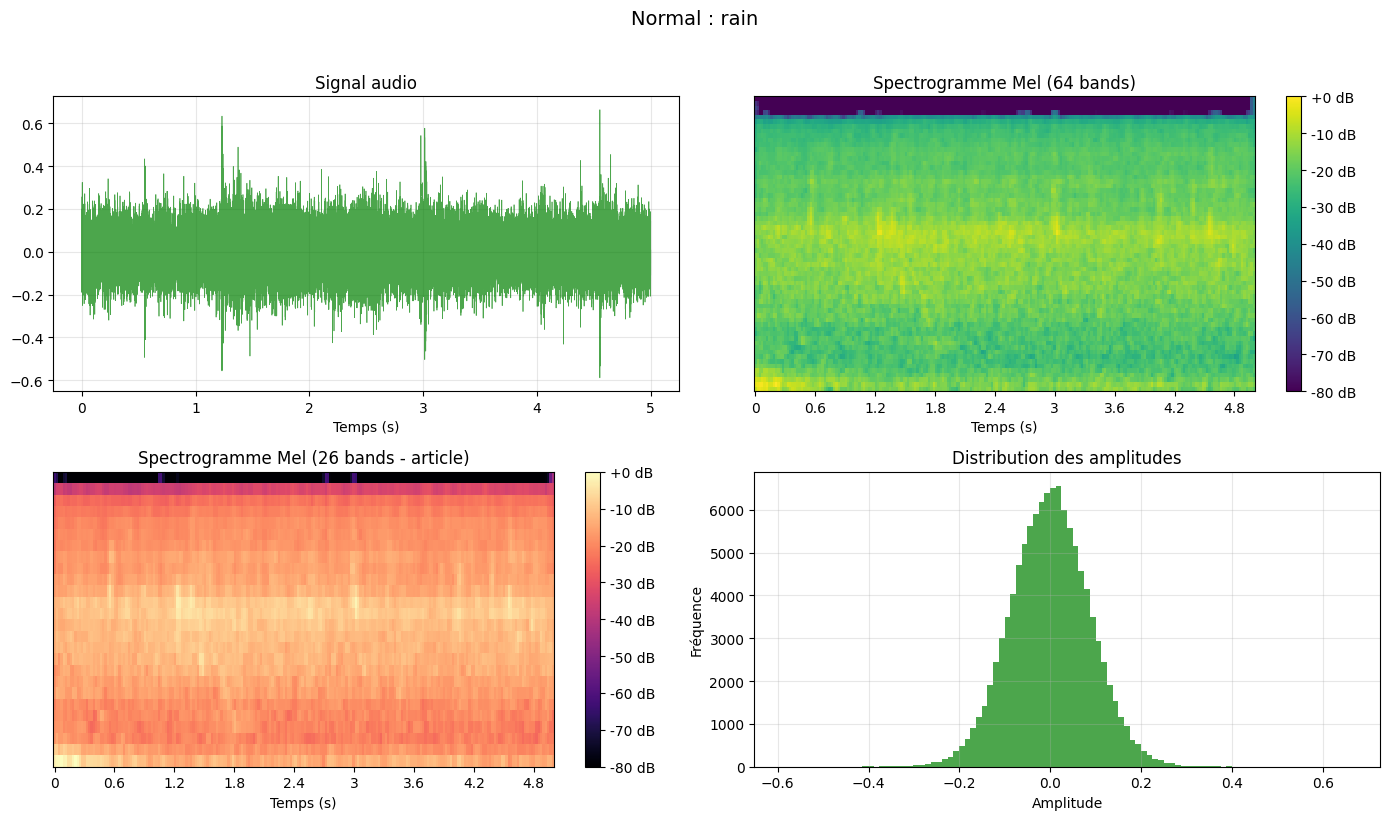


 NORMAL : wind
 Fichier : 1-137296-A-16.wav
  Durée : 5.00s
🎧 Écoute :


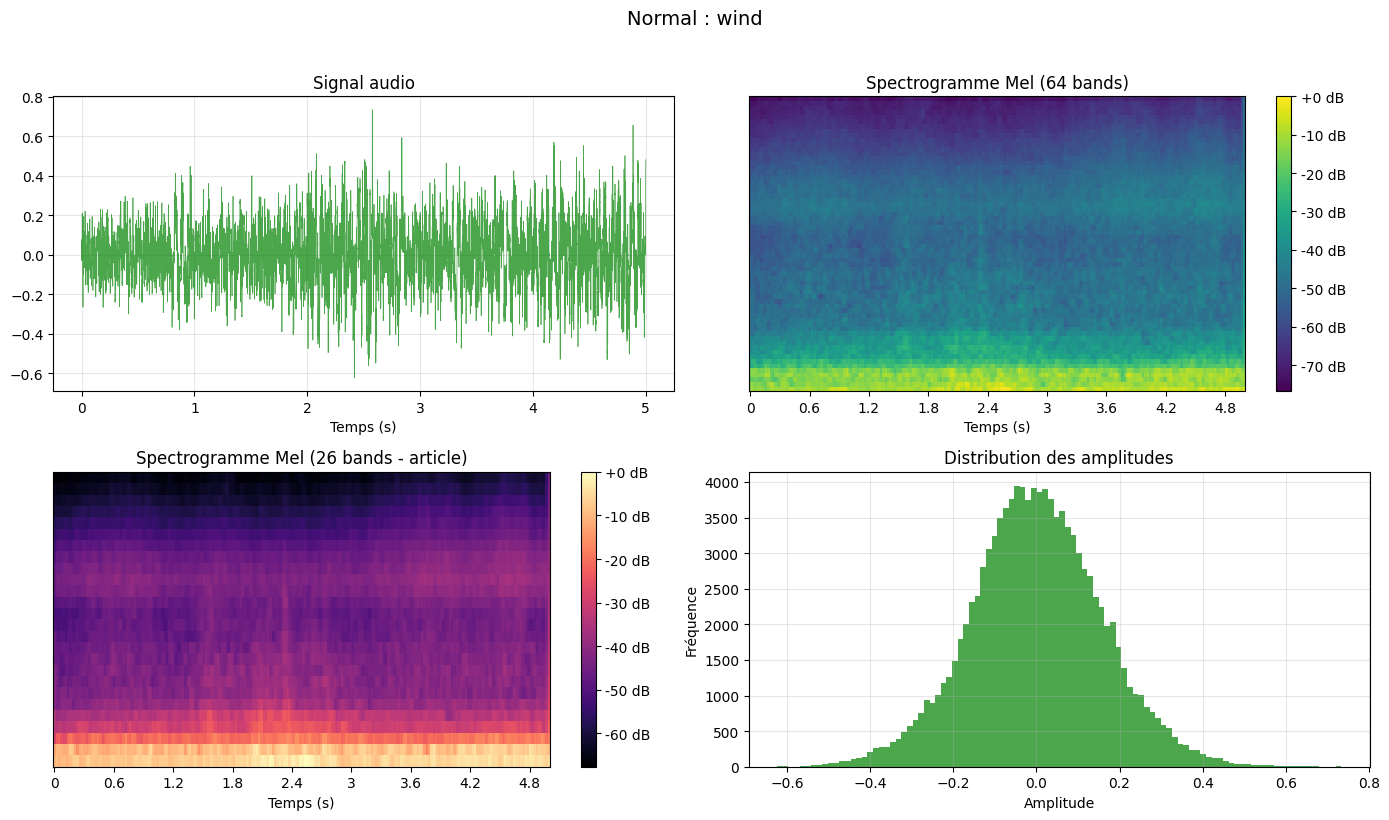


 CLASSES ANORMALES (1) :

 ANORMAL : glass_breaking
 Fichier : 1-20133-A-39.wav
  Durée : 5.00s
🎧 Écoute :


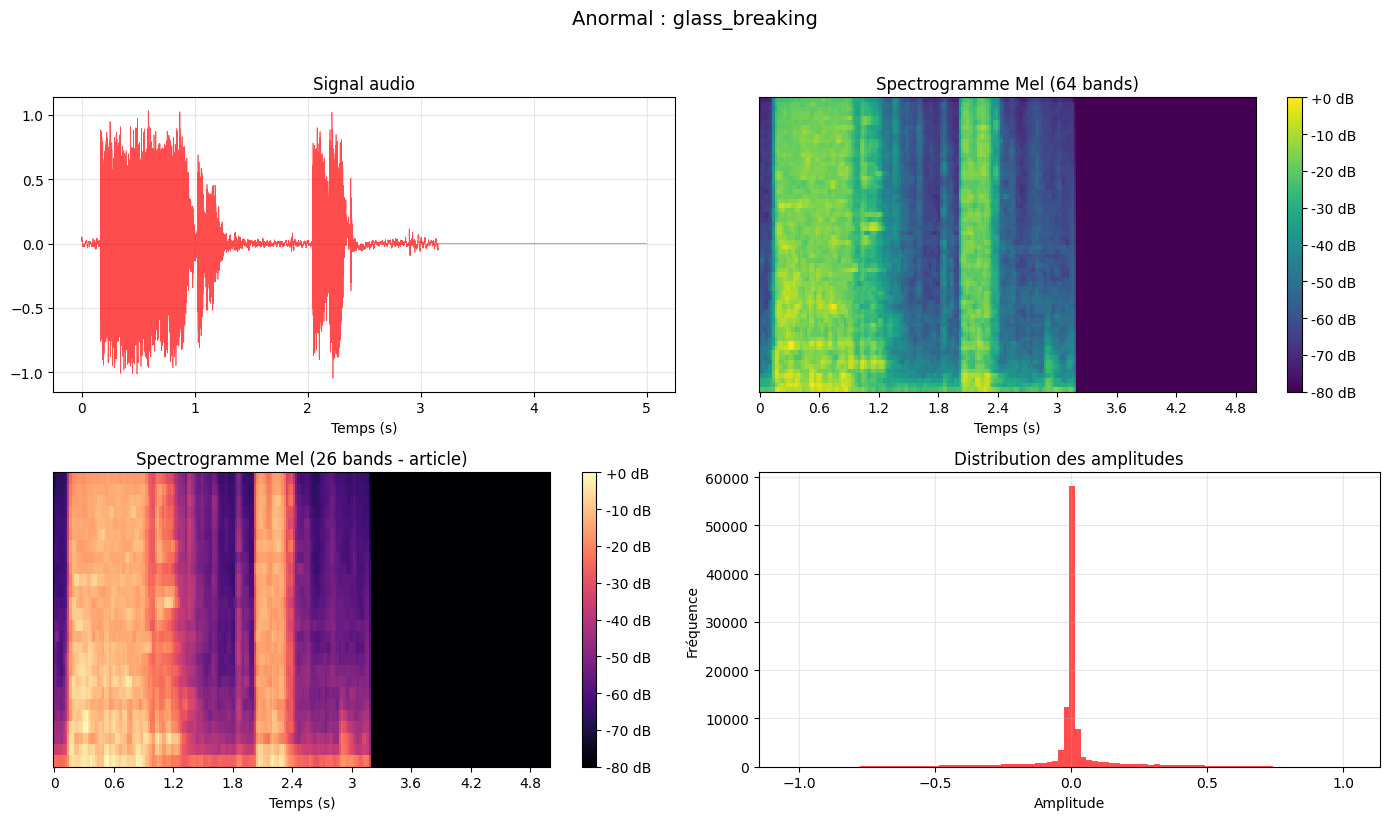

In [46]:
compare_classes(NORMAL_CLASSES, ANOMALOUS_CLASSES)

In [49]:

def load_files(path_meta, path_audio, normal_classes, anomalous_classes):
    normal_files = []
    anomalous_files = []

    with open(path_meta, "r") as f:
        reader = csv.DictReader(f)
        for row in reader:
            filename = row["filename"]
            category = row["category"]

            full_path = os.path.join(path_audio, filename)

            if not os.path.exists(full_path):
                continue

            if category in normal_classes:
                normal_files.append(full_path)
            elif category in anomalous_classes:
                anomalous_files.append(full_path)
            # sinon : on ignore la classe

    return normal_files, anomalous_files


normal_files, anomalous_files = load_files(
    ESC_PATH_META,
    ESC_PATH_AUDIO,
    NORMAL_CLASSES,
    ANOMALOUS_CLASSES
)

print(f"Normal files: {len(normal_files)}")
print(f"Anomalous files: {len(anomalous_files)}")



Normal files: 80
Anomalous files: 40


In [78]:

from tqdm import tqdm

def extract_features(filepath, sr=16000):
    y, _ = librosa.load(filepath, sr=sr)
    # Paramètres : fenêtre 30ms (480 pts), hop 10ms (160 pts)
    n_fft = int(0.03 * sr)
    hop_length = int(0.01 * sr)

    # 1. Mel-spectrogramme (26 bands)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=26, n_fft=n_fft, hop_length=hop_length)
    mel_log = np.log(mel_spec + 1e-6)

    # 2. Delta Mel
    delta_mel = np.diff(mel_log, axis=1, prepend=mel_log[:, :1])

    # 3. Énergie (RMS)
    rms = librosa.feature.rms(y=y, frame_length=n_fft, hop_length=hop_length)
    delta_rms = np.diff(rms, axis=1, prepend=rms[:, :1])

    # Concatenation -> (54, Temps)
    features = np.vstack([mel_log, delta_mel, rms, delta_rms])
    return features.T # (Temps, 54)



In [80]:


# Définition des classes
NORMAL_CLASSES = ['rain', 'wind', 'sea_waves' ]
ABNORMAL_CLASSES = ['glass_breaking']

df = pd.read_csv('ESC-50-master/meta/esc50.csv')
normal_data = []
abnormal_data = []

print("Extraction des features ...")
for _, row in tqdm(df.iterrows(), total=len(df)):
    if row['category'] in NORMAL_CLASSES or row['category'] in ABNORMAL_CLASSES:
        path = os.path.join('ESC-50-master/audio', row['filename'])
        feat = extract_features(path)
        # On force 500 frames (5 secondes)
        if len(feat) > 500: feat = feat[:500, :]
        else: feat = np.pad(feat, ((0, 500-len(feat)), (0, 0)))

        if row['category'] in NORMAL_CLASSES:
            normal_data.append(feat)
        else:
            abnormal_data.append(feat)

normal_data = np.array(normal_data)
abnormal_data = np.array(abnormal_data)
print(f"\n✅ Terminé : {len(normal_data)} fichiers normaux, {len(abnormal_data)} anormaux.")

Extraction des features ...


100%|██████████| 2000/2000 [00:03<00:00, 620.30it/s]


✅ Terminé : 120 fichiers normaux, 40 anormaux.


In [83]:
# Shuffle
np.random.shuffle(normal_data)

split = int(0.8 * len(normal_data))
X_train = normal_data[:split]
X_test_normal = normal_data[split:]
X_test_anom = abnormal_data


In [85]:
mean = X_train.mean(axis=(0, 1), keepdims=True)
std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

X_train = (X_train - mean) / std
X_test_normal = (X_test_normal - mean) / std
X_test_anom = (X_test_anom - mean) / std

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_normal = torch.tensor(X_test_normal, dtype=torch.float32).to(device)
X_test_anom = torch.tensor(X_test_anom, dtype=torch.float32).to(device)


In [86]:
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, X_train)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)


In [88]:
class DAEBLSTM(nn.Module):
    """
    Denoising AE avec BLSTM
    Conforme à l'article de réference

    Différences clés avec autoencodeur standard:
    1. Entraîné sur données corrompues (bruitées)
    2. Doit reconstruire la version PROPRE
    3. Fonction de perte: MSE entre reconstruction et entrée propre
    """

    def __init__(self, input_size, hidden_size, num_layers=2, bidirectional=True, noise_std=0.25):
        super().__init__()

        self.noise_std = noise_std  # σ = 0.25 comme dans l'article
        self.bidirectional = bidirectional

        # === ENCODEUR === 
        self.encoder = nn.LSTM(
            input_size=input_size,           # 54 bandes mel (comme article)
            hidden_size=hidden_size,         # 128-256 comme dans article
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0,
            bidirectional=bidirectional
        )

        # === DÉCODEUR ===
        # Dans l'article: architecture symétrique
        encoder_output_size = hidden_size * 2 if bidirectional else hidden_size

        self.decoder = nn.LSTM(
            input_size=encoder_output_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )

        # === COUCHE DE RECONSTRUCTION ===
        # Doit retrouver exactement input_size (54)
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, input_size),
            nn.Sigmoid()  # Nos features sont normalisées [0,1]
        )

        print(f"[INFO] DAE-BLSTM initialisé avec:")
        print(f"       • Bruit standard: σ={noise_std}")
        print(f"       • Bidirectionnel: {bidirectional}")
        print(f"       • Hidden size: {hidden_size}")
        print(f"       • Couches LSTM: {num_layers}")

    def add_noise(self, x):
        """Corruption par bruit Gaussien comme dans l'article"""
        if self.training and self.noise_std > 0:
            noise = torch.randn_like(x) * self.noise_std
            return x + noise
        return x

    def forward(self, x, return_latent=False):
        """
        Passe forward DAE:
        1. Corruption (en entraînement seulement)
        2. Encodage
        3. Décodage
        4. Reconstruction


        x: Input propre [batch, seq_len, features]
        return_latent: Si True, retourne aussi l'espace latent
        """
        batch_size, seq_len, n_features = x.shape

        # Étape 1: Corruption (DENOISING autoencoder)
        if self.training:
            x_corrupted = self.add_noise(x)
        else:
            x_corrupted = x  # Pas de bruit en inférence

        # Étape 2: Encodage
        encoded_outputs, (hidden, cell) = self.encoder(x_corrupted)

        # Étape 3: Décodage (à partir du dernier état caché)
        # Initialisation avec les états finaux de l'encodeur
        decoder_input = encoded_outputs  # Dans l'article, ils utilisent la sortie encodée

        decoded_outputs, _ = self.decoder(decoder_input)

        # Étape 4: Reconstruction des features originales
        reconstructed = self.output_layer(decoded_outputs)

        if return_latent:
            return reconstructed, encoded_outputs
        return reconstructed


In [89]:
model = DAEBLSTM(
    input_size=54,
    hidden_size=128,
    num_layers=2,
    bidirectional=True,
    noise_std=0.25
).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

[INFO] DAE-BLSTM initialisé avec:
       • Bruit standard: σ=0.25
       • Bidirectionnel: True
       • Hidden size: 128
       • Couches LSTM: 2


In [90]:
train_losses = []

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()

        recon = model(x)
        loss = criterion(recon, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {avg_loss:.6f}")


Epoch [1/100] - Loss: 1.248276
Epoch [2/100] - Loss: 1.240972
Epoch [3/100] - Loss: 1.218635
Epoch [4/100] - Loss: 1.181781
Epoch [5/100] - Loss: 1.132891
Epoch [6/100] - Loss: 1.085623
Epoch [7/100] - Loss: 1.041354
Epoch [8/100] - Loss: 1.001341
Epoch [9/100] - Loss: 0.970637
Epoch [10/100] - Loss: 0.945287
Epoch [11/100] - Loss: 0.925519
Epoch [12/100] - Loss: 0.910230
Epoch [13/100] - Loss: 0.900221
Epoch [14/100] - Loss: 0.893213
Epoch [15/100] - Loss: 0.888199
Epoch [16/100] - Loss: 0.884241
Epoch [17/100] - Loss: 0.881008
Epoch [18/100] - Loss: 0.878507
Epoch [19/100] - Loss: 0.876416
Epoch [20/100] - Loss: 0.874980
Epoch [21/100] - Loss: 0.873420
Epoch [22/100] - Loss: 0.872056
Epoch [23/100] - Loss: 0.871047
Epoch [24/100] - Loss: 0.869905
Epoch [25/100] - Loss: 0.869255
Epoch [26/100] - Loss: 0.868355
Epoch [27/100] - Loss: 0.867420
Epoch [28/100] - Loss: 0.866821
Epoch [29/100] - Loss: 0.866155
Epoch [30/100] - Loss: 0.865551
Epoch [31/100] - Loss: 0.865057
Epoch [32/100] - 

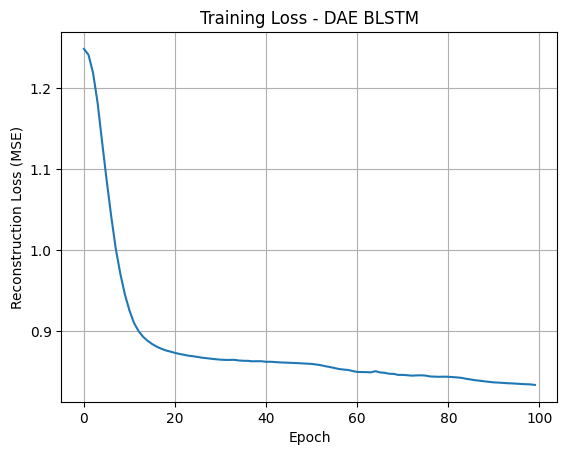

In [91]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Training Loss - DAE BLSTM")
plt.grid(True)
plt.show()


In [94]:
def compute_anomaly_scores(model, X):
    model.eval()
    scores = []

    with torch.no_grad():
        for x in X:
            x = x.unsqueeze(0)  # [1, T, F]
            recon = model(x)
            score = torch.mean((x - recon) ** 2).item()
            scores.append(score)

    return np.array(scores)


In [97]:
err_normal = compute_anomaly_scores(model, X_test_normal)
err_anomaly = compute_anomaly_scores(model, X_test_anom)


In [98]:
print("Normal mean:", err_normal.mean())
print("Anomaly mean:", err_anomaly.mean())


Normal mean: 1.0188238111635048
Anomaly mean: 8.178613752126694


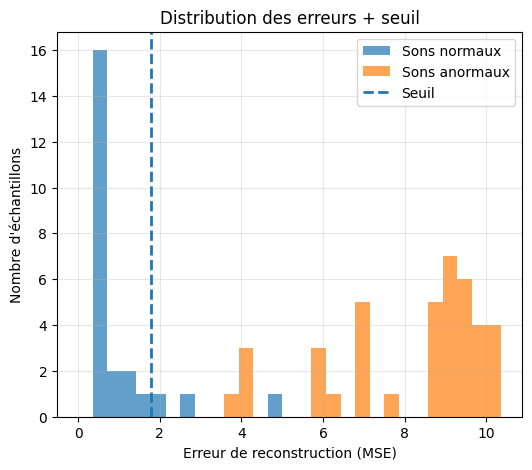

In [108]:
threshold = np.percentile(err_normal, 90)
fig, ax = plt.subplots(figsize=(6, 5))

bins = np.linspace(0, max(err_anomaly.max(), err_normal.max()), 30)
ax.hist(err_normal, bins=bins, alpha=0.7, label='Sons normaux')
ax.hist(err_anomaly, bins=bins, alpha=0.7, label='Sons anormaux')

ax.axvline(threshold, linestyle='--', linewidth=2, label='Seuil')

ax.set_xlabel('Erreur de reconstruction (MSE)')
ax.set_ylabel('Nombre d\'échantillons')
ax.set_title('Distribution des erreurs + seuil')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


On visualise ici sur ce petit example que l'erreur de reconstruction est bien plus élevée pour des sons "anormaux" que sur des sons normaux.

On passe maintenant aux variables de décision binaire pour pouvoir calculer des métriques similaires à celles de l'article.

In [103]:
y_true = np.concatenate([
    np.zeros(len(err_normal)),   # normaux
    np.ones(len(err_anomaly))    # anomalies
])

y_pred = np.concatenate([
    (err_normal > threshold).astype(int),
    (err_anomaly > threshold).astype(int)
])


In [104]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("\nMÉTRIQUES DE DÉTECTION ")
print(f"Precision : {precision*100:.2f} %")
print(f"Recall    : {recall*100:.2f} %")
print(f"F1-score  : {f1*100:.2f} %")



MÉTRIQUES DE DÉTECTION 
Precision : 93.02 %
Recall    : 100.00 %
F1-score  : 96.39 %


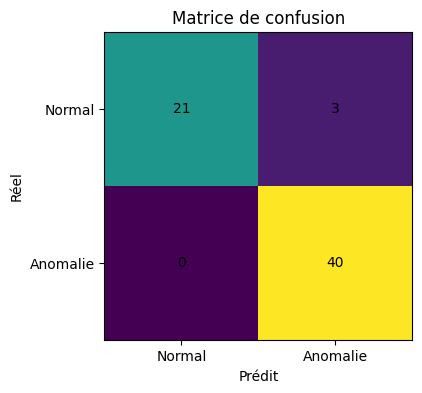

In [105]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(cm)

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Normal', 'Anomalie'])
ax.set_yticklabels(['Normal', 'Anomalie'])

ax.set_xlabel('Prédit')
ax.set_ylabel('Réel')
ax.set_title('Matrice de confusion')

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center')

plt.show()


In [106]:
thresholds = np.linspace(
    min(err_normal.min(), err_anomaly.min()),
    max(err_normal.max(), err_anomaly.max()),
    100
)

f1_scores = []

for th in thresholds:
    y_pred_tmp = np.concatenate([
        (err_normal > th).astype(int),
        (err_anomaly > th).astype(int)
    ])
    f1_scores.append(f1_score(y_true, y_pred_tmp))


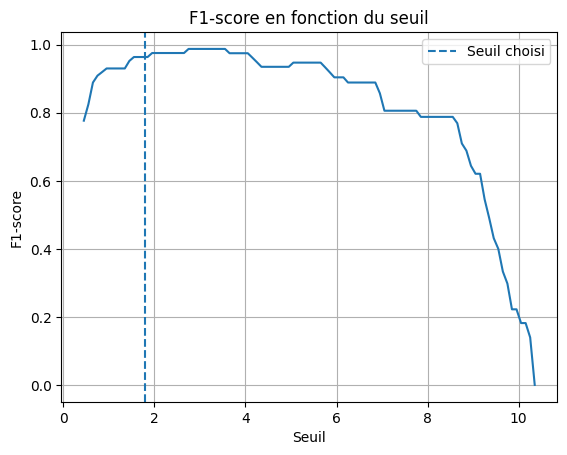

In [107]:
plt.figure()
plt.plot(thresholds, f1_scores)
plt.axvline(threshold, linestyle='--', label='Seuil choisi')
plt.xlabel("Seuil")
plt.ylabel("F1-score")
plt.title("F1-score en fonction du seuil")
plt.legend()
plt.grid(True)
plt.show()


Cette courbe nous permet de choisir le seuil optimal pour garantir un score F1 élevé.

# Etude plus complexe pour application industrielle

### TEST SUR DAE-BLSTM

Charger et préparer le dataset MIMII

In [114]:
data = np.load("mimii_fan_id00_6dB_10s.npz")

X_train = data["x_train"]          # normaux (train)
X_test_normal = data["x_test_normal"]
X_test_anom = data["x_test_abnormal"]

print(X_train.shape, X_test_normal.shape, X_test_anom.shape)


(1134, 313, 64) (284, 313, 64) (407, 313, 64)


Normalisation

In [115]:
mean = X_train.mean(axis=(0,1), keepdims=True)
std = X_train.std(axis=(0,1), keepdims=True) + 1e-8

X_train = (X_train - mean) / std
X_test_normal = (X_test_normal - mean) / std
X_test_anom = (X_test_anom - mean) / std


Conversion PyTorch

In [116]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_normal = torch.tensor(X_test_normal, dtype=torch.float32).to(device)
X_test_anom = torch.tensor(X_test_anom, dtype=torch.float32).to(device)

train_loader = DataLoader(
    TensorDataset(X_train, X_train),
    batch_size=32,
    shuffle=True,
    drop_last=True
)


Attention ! Ici on adapte le modèle à ce jeu de données qui contient 64 features et 10 sec par fichiers.

In [117]:
model = DAEBLSTM(
    input_size=64,
    hidden_size=128,
    num_layers=2,
    bidirectional=True,
    noise_std=0.25
).to(device)


[INFO] DAE-BLSTM initialisé avec:
       • Bruit standard: σ=0.25
       • Bidirectionnel: True
       • Hidden size: 128
       • Couches LSTM: 2


Entrainement

In [122]:
train_losses_MIMII = []

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()

        recon = model(x)
        loss = criterion(recon, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses_MIMII.append(epoch_loss / len(train_loader))
    if (int(epoch) % 10) == 0:
      print(f"Epoch [{epoch}/{EPOCHS}] - Loss: {avg_loss:.6f}")



Epoch [0/100] - Loss: 1.251792
Epoch [10/100] - Loss: 1.258285
Epoch [20/100] - Loss: 1.248713
Epoch [30/100] - Loss: 1.252538
Epoch [40/100] - Loss: 1.247844
Epoch [50/100] - Loss: 1.249115
Epoch [60/100] - Loss: 1.254275
Epoch [70/100] - Loss: 1.248338
Epoch [80/100] - Loss: 1.248416
Epoch [90/100] - Loss: 1.242799


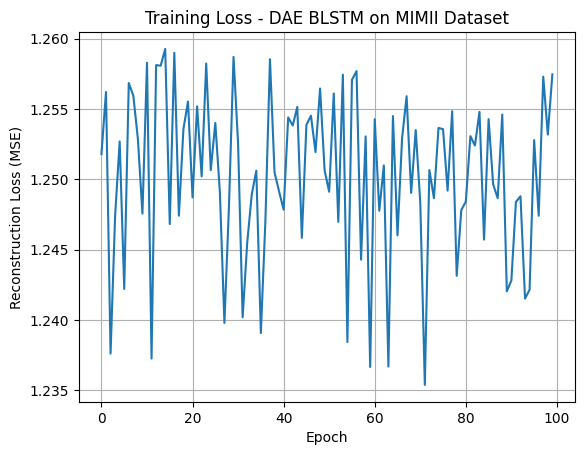

In [123]:
plt.figure()
plt.plot(train_losses_MIMII)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Training Loss - DAE BLSTM on MIMII Dataset")
plt.grid(True)
plt.show()

On observe une grosse instabilité de l'entrainement.

In [124]:
def anomaly_scores(model, X):
    model.eval()
    scores = []
    with torch.no_grad():
        for x in X:
            x = x.unsqueeze(0)
            recon = model(x)
            scores.append(torch.mean((x - recon) ** 2).item())
    return np.array(scores)


In [125]:
err_normal = anomaly_scores(model, X_test_normal)
err_anom = anomaly_scores(model, X_test_anom)


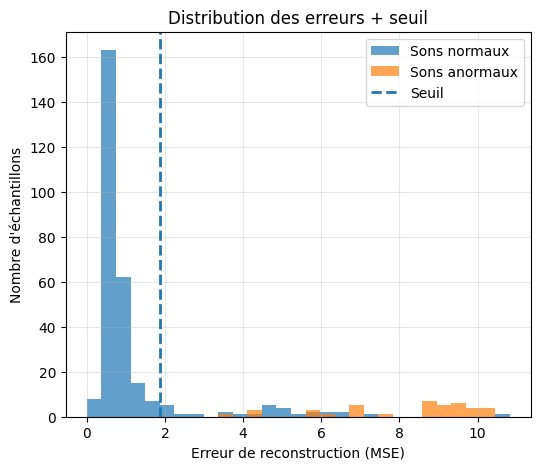

In [126]:
threshold = np.percentile(err_normal, 90)
fig, ax = plt.subplots(figsize=(6, 5))

bins = np.linspace(0, max(err_anomaly.max(), err_normal.max()), 30)
ax.hist(err_normal, bins=bins, alpha=0.7, label='Sons normaux')
ax.hist(err_anomaly, bins=bins, alpha=0.7, label='Sons anormaux')

ax.axvline(threshold, linestyle='--', linewidth=2, label='Seuil')

ax.set_xlabel('Erreur de reconstruction (MSE)')
ax.set_ylabel('Nombre d\'échantillons')
ax.set_title('Distribution des erreurs + seuil')
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()


Malgré l'instabilité à l'entrainement, il semble y avoir quand même une reconnaissance des sons anormaux. La distinction reste moins flagrante que pour des sons bien distincts.

In [127]:
y_true = np.concatenate([
    np.zeros(len(err_normal)),
    np.ones(len(err_anom))
])

y_pred = np.concatenate([
    (err_normal > threshold).astype(int),
    (err_anom > threshold).astype(int)
])

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"F1-score : {f1*100:.2f} %")


F1-score : 52.70 %


Le résultats de F1-score n'est pas très bon pour ce dataset plus complexe.

### Transformer : architecture plus moderne avec mécanisme d'attention

In [128]:
class TransformerDAE(nn.Module):
    def __init__(
        self,
        input_dim=64,
        d_model=128,
        num_heads=4,
        num_layers=4,
        dim_feedforward=256,
        dropout=0.1,
        noise_std=0.1,
        max_len=500
    ):
        super().__init__()

        self.noise_std = noise_std

        # Projection d'entrée
        self.input_proj = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)

        # Encodage de position appris
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Reconstruction
        self.output_proj = nn.Linear(d_model, input_dim)

    def forward(self, x):
        if self.training and self.noise_std > 0:
            x = x + torch.randn_like(x) * self.noise_std

        B, T, _ = x.shape

        x = self.input_proj(x)
        x = self.input_norm(x)
        x = x + self.pos_embedding[:, :T, :]

        x = self.encoder(x)
        return self.output_proj(x)


In [129]:
model = TransformerDAE(
    input_dim=64,
    d_model=128,
    num_heads=4,
    num_layers=4,
    dim_feedforward=256,
    noise_std=0.1
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [131]:
train_losses = []

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    if (int(epoch) % 10) == 0:
      print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.6f}")


Epoch 1/100 | Loss: 0.410522
Epoch 11/100 | Loss: 0.225385
Epoch 21/100 | Loss: 0.168084
Epoch 31/100 | Loss: 0.135791
Epoch 41/100 | Loss: 0.114901
Epoch 51/100 | Loss: 0.100352
Epoch 61/100 | Loss: 0.087729
Epoch 71/100 | Loss: 0.077944
Epoch 81/100 | Loss: 0.069644
Epoch 91/100 | Loss: 0.062879


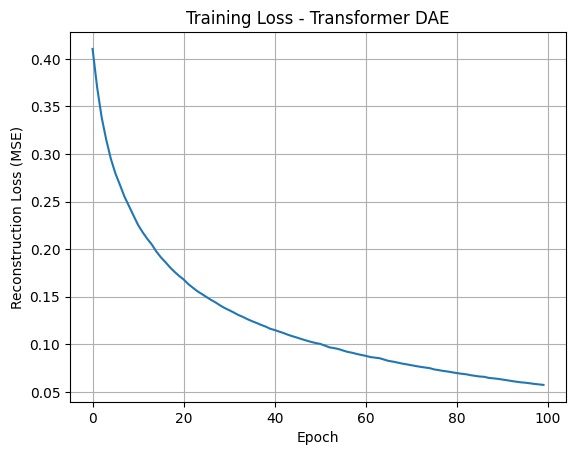

In [132]:
plt.figure()
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Loss (MSE)")
plt.title("Training Loss - Transformer DAE")
plt.grid(True)
plt.show()


In [133]:
def anomaly_scores(model, X):
    model.eval()
    scores = []
    with torch.no_grad():
        for x in X:
            x = x.unsqueeze(0)
            recon = model(x)
            scores.append(torch.mean((x - recon) ** 2).item())
    return np.array(scores)


In [134]:
from sklearn.metrics import classification_report

err_normal = anomaly_scores(model, X_test_normal)
err_anom = anomaly_scores(model, X_test_anom)

threshold = np.percentile(err_normal, 95)

y_true = np.concatenate([
    np.zeros(len(err_normal)),
    np.ones(len(err_anom))
])

y_pred = np.concatenate([
    (err_normal > threshold).astype(int),
    (err_anom > threshold).astype(int)
])

print(classification_report(y_true, y_pred, digits=3))


              precision    recall  f1-score   support

         0.0      0.422     0.947     0.584       284
         1.0      0.717     0.093     0.165       407

    accuracy                          0.444       691
   macro avg      0.569     0.520     0.374       691
weighted avg      0.596     0.444     0.337       691



Les résultats montrent que le Transformer peine à séparer efficacement les distributions des erreurs de reconstruction associées aux sons normaux et anormaux. La forte valeur de rappel pour la classe normale, combinée à un rappel très faible pour la classe anormale, indique que le modèle a tendance à reconstruire de manière similaire les deux types de signaux.

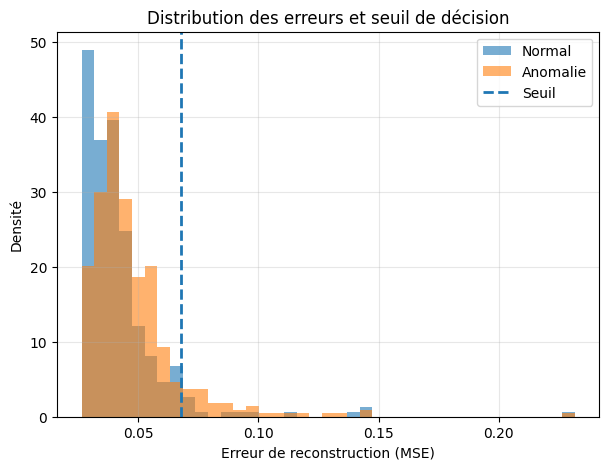

In [135]:
plt.figure(figsize=(7, 5))

bins = np.linspace(
    min(err_normal.min(), err_anom.min()),
    max(err_normal.max(), err_anom.max()),
    40
)

plt.hist(err_normal, bins=bins, alpha=0.6, label="Normal", density=True)
plt.hist(err_anom, bins=bins, alpha=0.6, label="Anomalie", density=True)

plt.axvline(threshold, linestyle="--", linewidth=2, label="Seuil")

plt.xlabel("Erreur de reconstruction (MSE)")
plt.ylabel("Densité")
plt.title("Distribution des erreurs et seuil de décision")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


Ici encore, le transformer ne semble pas bien séparer les données. Il faudrait finetuner les hypeerparamètres du transformer (aisni que du DAE-BLSTM) pour améliorer l'efficacité de l'algorithme.

Contrairement au DAE-BLSTM, qui exploite explicitement la dynamique temporelle séquentielle du signal, le Transformer repose sur un mécanisme d’attention globale qui nécessite un réglage plus fin et davantage de données pour être pleinement exploité dans un cadre de détection d’anomalies audio.

# Conclusion
Une optimisation plus poussée des hyperparamètres du Transformer, ainsi que du DAE-BLSTM, serait nécessaire afin d’améliorer significativement les performances du système. Toutefois, en raison des contraintes de temps, cette phase de fine-tuning approfondi n’a pas pu être menée dans le cadre de ce travail.

L’objectif principal de cette expérimentation était d’introduire et d’évaluer une architecture plus récente, basée sur les Transformers, dans un cadre de détection d’anomalies audio non supervisée. Les Transformers présentent en effet des avantages théoriques majeurs, notamment la possibilité de paralléliser le traitement des séquences et de s’affranchir des limitations inhérentes aux réseaux récurrents, telles que le traitement strictement séquentiel et les phénomènes d’évanescence du gradient.